## Practical Assessment – NLP Data Scientist 
Using advanced NLP and ML techniques to explore, model, and anonymise patient behavior data 


### Exploratory Data Analysis (EDA)

##### Import libraries

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Analysis configuration
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 6)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 1. Data Quality Assessment & Preprocessing
#### 1.1 Data Loading & Initial Inspection

In [60]:
# Load the data
df = pd.read_csv('data/patient_behavior_data.csv', delimiter=';')

#store a copy of the original dataframe
data = df.copy()

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst few records:")
df.head()

Dataset Shape: (19999, 19)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       19999 non-null  int64  
 1   gender           19999 non-null  object 
 2   medication       16720 non-null  object 
 3   dose             16651 non-null  object 
 4   name             19999 non-null  object 
 5   surname          19999 non-null  object 
 6   bmi              19999 non-null  float64
 7   weight           19999 non-null  float64
 8   height           19999 non-null  float64
 9   systolic         19999 non-null  int64  
 10  diastolic        19999 non-null  int64  
 11  concentration    19999 non-null  int64  
 12  distractibility  19999 non-null  int64  
 13  impulsivity      19999 non-null  int64  
 14  hyperactivity    19999 non-null  int64  
 15  sleep            19999 non-null  int64  
 16  mood            

,patient_id,gender,medication,dose,name,surname,bmi,weight,height,systolic,diastolic,concentration,distractibility,impulsivity,hyperactivity,sleep,mood,appetite,doctor_notes
0,1,Other,Adderall,15mg,Ashley,Merritt,26.80,82.90,1.76,113,88,1,0,-2,0,2,2,0,Needs review of medication due to side effects...
1,2,Other,NaN,NaN,Joseph,Salazar,17.30,52.30,1.74,136,72,-2,1,-2,1,1,2,1,No significant behavioral changes observed. Ye...
2,3,Male,Vyvanse,15mg,Barbara,Roberts,35.50,114.90,1.80,128,77,0,2,-1,-2,2,2,-2,Mood swings noted during follow-up. Both set T...
3,4,Female,NaN,5mg,Dawn,Brown,36.50,91.20,1.58,101,78,0,-2,-1,2,1,0,-2,Increased talkativeness and interrupting behav...
4,5,Female,Vyvanse,30mg,Robert,Warner,17.70,40.40,1.51,111,81,1,0,1,1,2,-1,0,Significant improvement in appetite. Large sig...


#### 1.2 Data Quality Checks

In [61]:
def perform_data_quality_checks(df):
    
    print("1. Missing Values Check:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0] if missing_values.any() else "No missing values found")
    
    print("\n2. Duplicate Records Check:")
    duplicates = df.duplicated().sum()
    print(f"Found {duplicates} duplicate records")
    
    print("\n3. Unique Values in Categorical Columns:")
    categorical_cols = ['gender', 'medication', 'dose', 'concentration', 'distractibility', 'impulsivity',
                        'hyperactivity','sleep','mood','appetite']
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())
    
    print("\n4. Numerical Columns Statistics:")
    numerical_cols = ['bmi', 'weight', 'height', 'systolic', 'diastolic' ]
    print(df[numerical_cols].describe())
    

perform_data_quality_checks(df)

1. Missing Values Check:
medication    3279
dose          3348
dtype: int64

2. Duplicate Records Check:
Found 0 duplicate records

3. Unique Values in Categorical Columns:

gender:
gender
Male      6716
Female    6669
Other     6614
Name: count, dtype: int64

medication:
medication
Adderall     3390
Vyvanse      3386
Concerta     3336
Ritalin      3311
Strattera    3297
Name: count, dtype: int64

dose:
dose
15mg    3431
30mg    3340
10mg    3338
5mg     3283
20mg    3259
Name: count, dtype: int64

concentration:
concentration
 2    4031
-1    4016
 0    3997
-2    3994
 1    3961
Name: count, dtype: int64

distractibility:
distractibility
 0    4092
-2    4048
 1    3997
-1    3979
 2    3883
Name: count, dtype: int64

impulsivity:
impulsivity
 2    4085
 1    4067
-2    3975
-1    3963
 0    3909
Name: count, dtype: int64

hyperactivity:
hyperactivity
-1    4103
 0    4030
 2    3977
-2    3954
 1    3935
Name: count, dtype: int64

sleep:
sleep
-1    4036
 2    4021
 1    4003
 0    

#### 1.3 Data Preprocessing

##### 1.3.1 Handling Missing Values `medication` and `dose`

In [62]:
#Investigating NaN Relationship
print("\nChecking if medication NaN implies dose NaN:")
print(df[df['medication'].isnull()]['dose'].isnull().all())
print("\nChecking if dose NaN implies medication NaN:")
print(df[df['dose'].isnull()]['medication'].isnull().all())
print("\nRows where medication is not NaN but dose is NaN:")
print(df[df['medication'].notnull() & df['dose'].isnull()])


Checking if medication NaN implies dose NaN:
False

Checking if dose NaN implies medication NaN:
False

Rows where medication is not NaN but dose is NaN:


       patient_id  gender medication dose       name     surname   bmi  \
9              10    Male   Adderall  NaN       Ryan     Mcclure 39.20   
16             17  Female  Strattera  NaN        Joy     Johnson 17.50   
31             32   Other  Strattera  NaN    Charles       Poole 24.50   
42             43   Other   Adderall  NaN     Ronald       Moore 40.10   
52             53    Male    Vyvanse  NaN        Joy  Richardson 39.80   
...           ...     ...        ...  ...        ...         ...   ...   
19951       19952    Male  Strattera  NaN       Sean      Cooper 21.70   
19964       19965  Female   Concerta  NaN  Elizabeth    Schaefer 33.60   
19972       19973  Female    Vyvanse  NaN     Nicole        Reed 38.60   
19986       19987    Male   Adderall  NaN     Andrew      Maddox 10.60   
19991       19992  Female    Ritalin  NaN     Brandy    Roberson 16.50   

       weight  height  systolic  diastolic  concentration  distractibility  \
9       91.80    1.53       113  

In [63]:
# Creating is_medicated (Binary Feature)
df['is_medicated'] = np.where(df['medication'].isnull(), 0, 1)

# Preprocess dose column (Convert string doses like '5mg' to numeric)
def parse_dose(dose_str):
    if pd.isna(dose_str):
        return np.nan
    if isinstance(dose_str, (int, float)): # If it's already numeric
        return float(dose_str)
    # Use regex to extract numbers. Handles integers and decimals.
    match = re.search(r'(\d+\.?\d*)\s*mg', str(dose_str), re.IGNORECASE)
    if match:
        return float(match.group(1))
    return np.nan # Return NaN if format is unexpected or no 'mg' unit

df['dose_mg'] = df['dose'].apply(parse_dose)
print("\nDataFrame head after parsing dose to numeric:")
print(df[['medication', 'dose', 'dose_mg', 'is_medicated']].head(10))
print("\nNaN counts in dose_mg before imputation:")
print(df['dose_mg'].isnull().sum())


DataFrame head after parsing dose to numeric:
  medication  dose  dose_mg  is_medicated
0   Adderall  15mg    15.00             1
1        NaN   NaN      NaN             0
2    Vyvanse  15mg    15.00             1
3        NaN   5mg     5.00             0
4    Vyvanse  30mg    30.00             1
5   Adderall  10mg    10.00             1
6  Strattera  15mg    15.00             1
7  Strattera   5mg     5.00             1
8   Concerta  30mg    30.00             1
9   Adderall   NaN      NaN             1

NaN counts in dose_mg before imputation:
3348


In [ ]:
# Impute medication (Categorical)
# Store original medication NaNs for dose imputation logic
original_medication_nan_mask = df['medication'].isnull()
df['medication'].fillna('NoMedication', inplace=True)

# Impute dose_mg (Numerical)
# Primary Case: If original medication was NaN (now "NoMedication"), set dose_mg to 0
# We use original_medication_nan_mask to identify these rows
df.loc[original_medication_nan_mask, 'dose_mg'] = df.loc[original_medication_nan_mask, 'dose_mg'].fillna(0)

# Edge Case: Medication is not "NoMedication", but dose_mg is NaN
# Impute with median dose_mg for that specific medication
for med_name in df[df['medication'] != 'NoMedication']['medication'].unique():
    # Calculate median dose for this specific medication, using 'dose_mg' and excluding NaNs
    median_dose_for_med = df[(df['medication'] == med_name) & (df['dose_mg'].notnull())]['dose_mg'].median()
    
    # If median_dose_for_med is NaN (e.g., all numeric doses for this med were NaN initially, or only one entry which was NaN)
    # then fall back to 0.
    if pd.isna(median_dose_for_med):
        median_dose_for_med = 0 # Fallback, or use overall median: df['dose_mg'].median()
        
    # Get mask for rows with this medication and NaN in 'dose_mg'
    dose_numeric_nan_for_this_med_mask = (df['medication'] == med_name) & (df['dose_mg'].isnull())
    df.loc[dose_numeric_nan_for_this_med_mask, 'dose_mg'] = median_dose_for_med

# If any 'dose_mg' are still NaN (e.g., a new medication with all NaN doses), fill with 0 as a final fallback.
df['dose_mg'].fillna(0, inplace=True)


print("\nDataFrame head after NaN handling (medication and dose_mg):")
print(df[['medication', 'dose', 'dose_mg', 'is_medicated']].head(10))
print("\nNaN counts after processing medication and dose_mg:")
print(df[['medication', 'dose_mg', 'is_medicated']].isnull().sum())


DataFrame head after NaN handling (medication and dose_mg):
     medication  dose  dose_mg  is_medicated
0      Adderall  15mg    15.00             1
1  NoMedication   NaN     0.00             0
2       Vyvanse  15mg    15.00             1
3  NoMedication   5mg     5.00             0
4       Vyvanse  30mg    30.00             1
5      Adderall  10mg    10.00             1
6     Strattera  15mg    15.00             1
7     Strattera   5mg     5.00             1
8      Concerta  30mg    30.00             1
9      Adderall   NaN    15.00             1

NaN counts after processing medication and dose_mg:
medication      0
dose_mg         0
is_medicated    0
dtype: int64


##### 1.3.2 More Derived Features

In [65]:
# BMI Category
# Standard WHO BMI categories
bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

# Blood Pressure (BP) Category
# Based on ACC/AHA 2017 Guidelines (Simplified - should consult current medical guidelines for precise definitions on this)
def get_bp_category(row):
    systolic = row['systolic']
    diastolic = row['diastolic']
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic <= 129 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic <= 139 or 80 <= diastolic <= 89:
        return 'Hypertension Stage 1'
    elif systolic >= 140 or diastolic >= 90: # Simplified, Stage 2 starts here
        return 'Hypertension Stage 2'
    # Hypertensive crisis (e.g. >180 and/or >120) could be added
    return 'Undefined' # Should not happen with typical values

df['bp_category'] = df.apply(get_bp_category, axis=1)

print("\nNaN counts in the entire DataFrame after all processing:")
print(df.isnull().sum())


NaN counts in the entire DataFrame after all processing:
patient_id            0
gender                0
medication            0
dose               3348
name                  0
surname               0
bmi                   0
weight                0
height                0
systolic              0
diastolic             0
concentration         0
distractibility       0
impulsivity           0
hyperactivity         0
sleep                 0
mood                  0
appetite              0
doctor_notes          0
is_medicated          0
dose_mg               0
bmi_category          0
bp_category           0
dtype: int64


#### Data Quality Summary

In [66]:
print("\nNaN counts in the entire DataFrame after all processing:")
final_nan_counts = df.isnull().sum()
print(final_nan_counts)

print("\n--- Data Quality Summary (Post-Processing) ---")
print(f"Total number of rows (patients): {len(df)}")
print(f"Total number of columns (features): {len(df.columns)}")

print("\nData Types:")
# Check for 'object' types that might need further attention (excluding 'doctor_notes' which is expected text)
object_cols = df.select_dtypes(include='object').columns.tolist()
if 'doctor_notes' in object_cols:
    object_cols.remove('doctor_notes') # Expected to be object
if object_cols:
    print(f"  Object type columns (excluding doctor_notes) that may need review: {object_cols}")
else:
    print("  No unexpected object type columns (doctor_notes is expected text).")

# Check for 'category' types from pd.cut
category_cols = df.select_dtypes(include='category').columns.tolist()
if category_cols:
    print(f"  Categorical columns created: {category_cols}")

print("\nMissing Values (Post-Processing):")
if final_nan_counts.sum() == 0:
    print("  No missing values remaining in the dataset. All NaNs handled.")
else:
    print("  Missing values still present in the following columns:")
    print(final_nan_counts[final_nan_counts > 0])

print("\nKey Column Checks:")
# Medication and Dose
if 'medication' in df.columns and 'NoMedication' in df['medication'].unique():
    print("  'medication' column: NaN values imputed with 'NoMedication'.")
else:
    print("  'medication' column: Check imputation status.")

if 'dose_mg' in df.columns and df['dose_mg'].isnull().sum() == 0:
    print("  'dose_mg' column: Successfully parsed and NaNs imputed (typically with 0 or median).")
elif 'dose_mg' in df.columns:
    print(f"  'dose_mg' column: Still has {df['dose_mg'].isnull().sum()} NaNs. Review imputation.")
else:
    print("  'dose_mg' column: Not found. Check parsing step.")

# Newly created categorical features NaN check (already done above, but good to summarize)
nan_in_derived_categories = df[category_cols].isnull().sum().sum()
if nan_in_derived_categories == 0:
    print(f"  Derived categorical features ({category_cols}) have no missing values.")
else:
    print(f"  WARNING: Derived categorical features have {nan_in_derived_categories} missing values. Check binning logic in pd.cut.")

print("\nFeature Overview:")
print(f"  Original features: {len(data.columns)}")
print(f"  Newly derived features added: {len(df.columns) - len(data.columns)}")
print("  Consider reviewing distributions of numerical features (e.g., using df.describe()) for outliers or unexpected ranges.")
print("--- End of Data Quality Summary ---")


# Check if any NaNs were introduced in categorical features if original values were outside all bins
print("\nNaNs in new categorical features specifically:")
print(df[['bmi_category', 'bp_category', 'is_medicated']].isnull().sum())

# Original 'dose' column is kept for reference, 'dose_mg' is used for analysis/modeling
print("\nFinal check on dose columns:")
print(df[['dose', 'dose_mg']].head(15))



NaN counts in the entire DataFrame after all processing:
patient_id            0
gender                0
medication            0
dose               3348
name                  0
surname               0
bmi                   0
weight                0
height                0
systolic              0
diastolic             0
concentration         0
distractibility       0
impulsivity           0
hyperactivity         0
sleep                 0
mood                  0
appetite              0
doctor_notes          0
is_medicated          0
dose_mg               0
bmi_category          0
bp_category           0
dtype: int64

--- Data Quality Summary (Post-Processing) ---
Total number of rows (patients): 19999
Total number of columns (features): 23

Data Types:
  Object type columns (excluding doctor_notes) that may need review: ['gender', 'medication', 'dose', 'name', 'surname', 'bp_category']
  Categorical columns created: ['bmi_category']

Missing Values (Post-Processing):
  Missing values st

### 2. Initial Data Exploration

Let's examine the basic patterns in our preprocessed data:

Generating basic distribution plots...


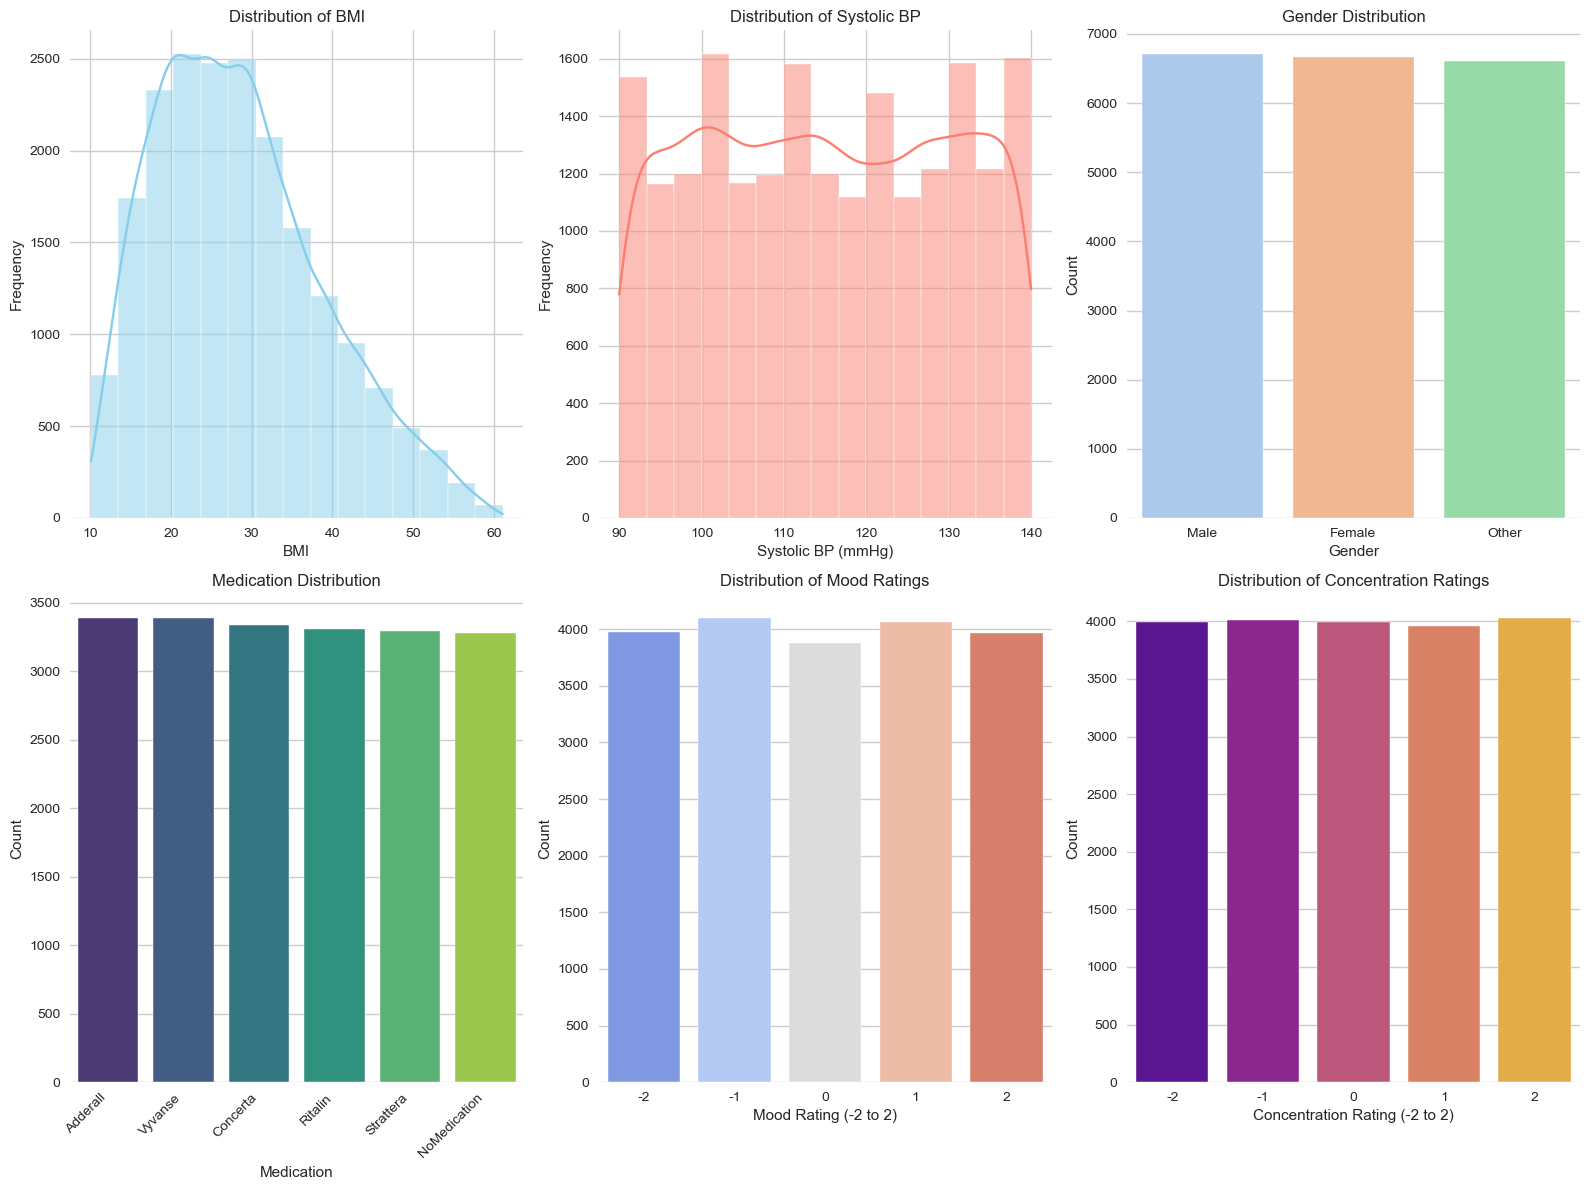

In [67]:
# Plotting function for basic distributions
def plot_basic_distributions(df):
    """
    Plots basic distributions for selected numerical and categorical features.
    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    print("Generating basic distribution plots...")
    
    # Set plot style
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 12))

    # BMI Distribution
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x='bmi', kde=True, bins=15, color='skyblue')
    plt.title('Distribution of BMI')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')

    # Systolic Blood Pressure Distribution
    plt.subplot(2, 3, 2)
    sns.histplot(data=df, x='systolic', kde=True, bins=15, color='salmon')
    plt.title('Distribution of Systolic BP')
    plt.xlabel('Systolic BP (mmHg)')
    plt.ylabel('Frequency')

    # Gender Distribution
    plt.subplot(2, 3, 3)
    gender_counts = df['gender'].value_counts()
    sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')

    # Medication Distribution
    plt.subplot(2, 3, 4)
    medication_counts = df['medication'].value_counts().nlargest(10) # Show top 10 if many
    sns.barplot(x=medication_counts.index, y=medication_counts.values, palette='viridis')
    plt.title('Medication Distribution')
    plt.xlabel('Medication')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate labels if long

    # Mood Rating Distribution
    # Behavioral ratings are -2 to 2. A countplot is suitable.
    plt.subplot(2, 3, 5)
    sns.countplot(data=df, x='mood', palette='coolwarm', order=sorted(df['mood'].unique()))
    plt.title('Distribution of Mood Ratings')
    plt.xlabel('Mood Rating (-2 to 2)')
    plt.ylabel('Count')

    # Concentration Rating Distribution
    plt.subplot(2, 3, 6)
    sns.countplot(data=df, x='concentration', palette='plasma', order=sorted(df['concentration'].unique()))
    plt.title('Distribution of Concentration Ratings')
    plt.xlabel('Concentration Rating (-2 to 2)')
    plt.ylabel('Count')

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

plot_basic_distributions(df)

#### 2.1 Key Metrics


Summary of BMI by Gender and Medication (Mean, Median, Std):
                     mean  median   std
gender medication                      
Female Adderall     27.99   26.45 10.24
       Concerta     28.67   27.90 10.37
       NoMedication 28.67   27.95 10.11
       Ritalin      28.15   26.80  9.99
       Strattera    28.17   26.40 10.28
       Vyvanse      29.18   28.00 10.75
Male   Adderall     28.28   26.60 10.32
       Concerta     28.28   27.10 10.30
       NoMedication 28.34   27.10 10.50
       Ritalin      29.02   27.90 10.45
       Strattera    28.27   26.90 10.69
       Vyvanse      28.76   27.70 10.28
Other  Adderall     28.52   27.10 10.37
       Concerta     28.70   27.50 10.26
       NoMedication 28.07   26.95 10.21
       Ritalin      29.20   28.10 10.58
       Strattera    28.76   27.20 10.58
       Vyvanse      27.97   27.30  9.82

Summary of Systolic BP by Gender and Medication (Mean, Median, Std):
                      mean  median   std
gender medication          

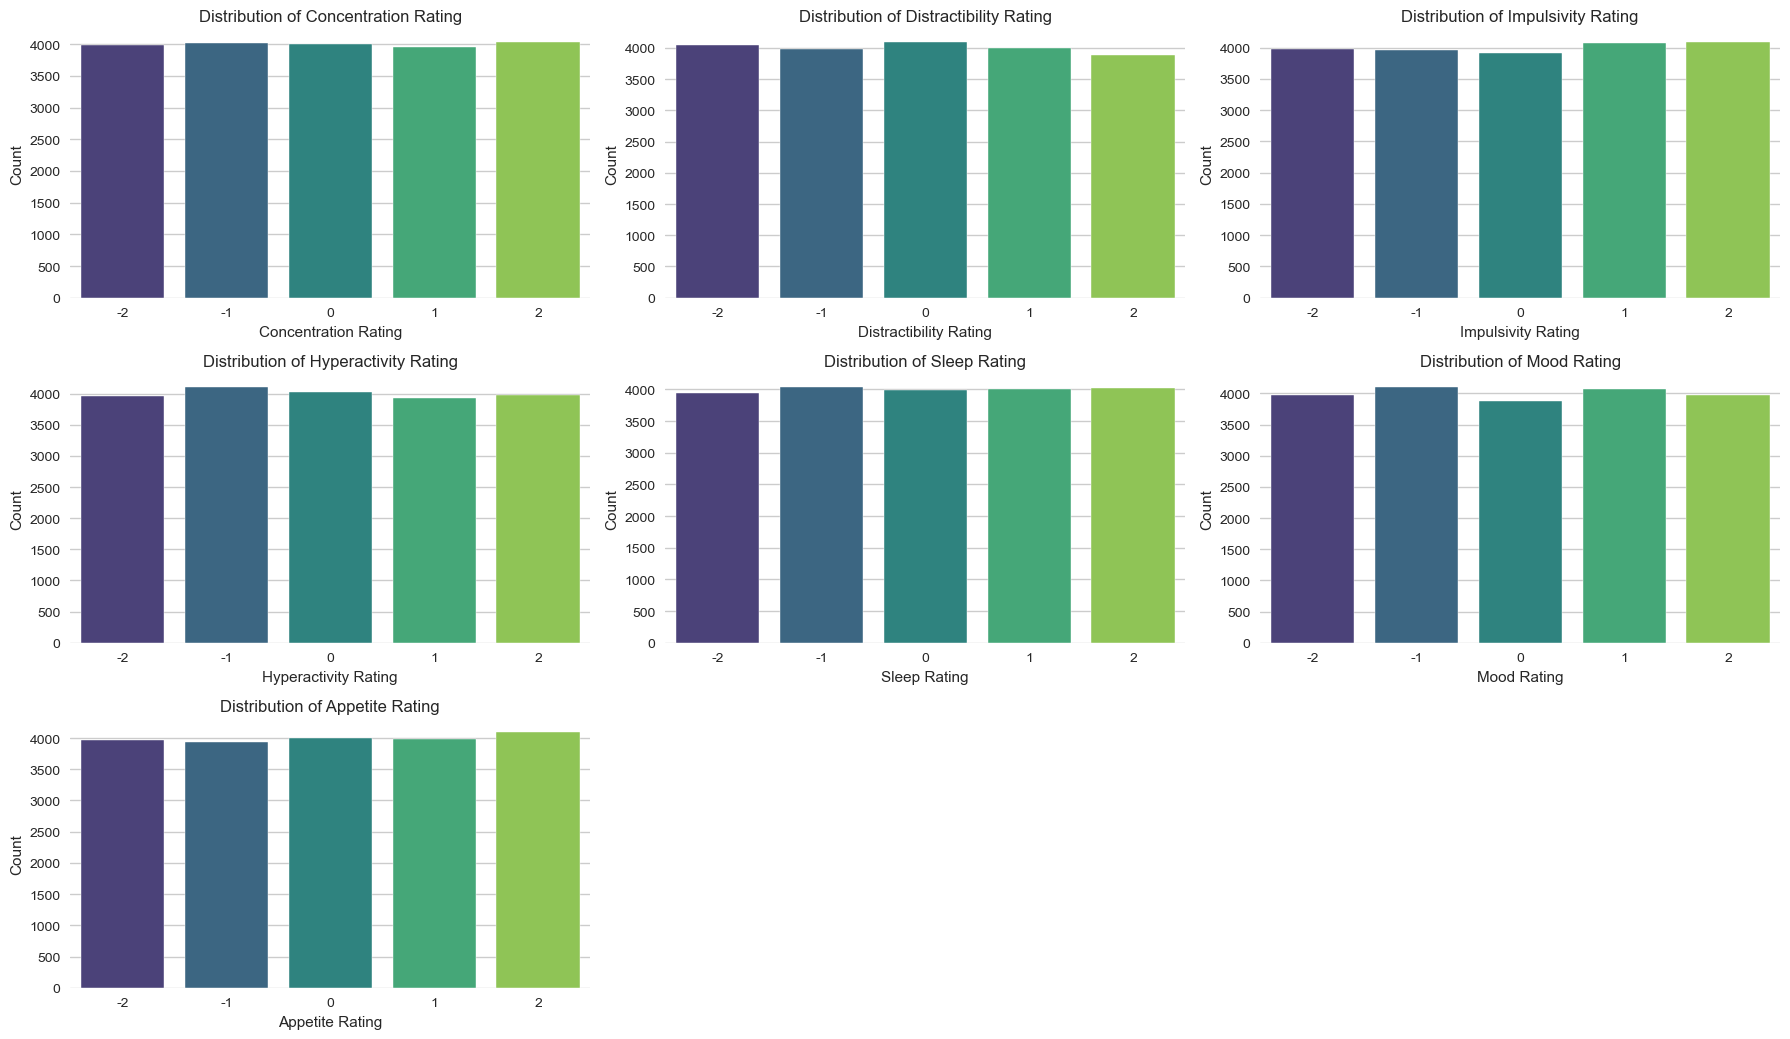

In [68]:
# BMI by gender and medication
print("\nSummary of BMI by Gender and Medication (Mean, Median, Std):")
bmi_summary = df.groupby(['gender', 'medication'])['bmi'].agg(['mean', 'median', 'std']).round(2)
print(bmi_summary)

# Blood pressure by gender and medication
print("\nSummary of Systolic BP by Gender and Medication (Mean, Median, Std):")
systolic_summary = df.groupby(['gender', 'medication'])['systolic'].agg(['mean', 'median', 'std']).round(2)
print(systolic_summary)

print("\nSummary of Diastolic BP by Gender and Medication (Mean, Median, Std):")
diastolic_summary = df.groupby(['gender', 'medication'])['diastolic'].agg(['mean', 'median', 'std']).round(2)
print(diastolic_summary)

# Distribution of behavioural ratings (-2 to 2)
print("\n--- 1.2 Distribution of Behavioural Ratings (-2 to 2) ---")
behavioural_cols = ['concentration', 'distractibility', 'impulsivity', 'hyperactivity', 'sleep', 'mood', 'appetite']

print("\nDescriptive Statistics for Behavioural Ratings:")
print(df[behavioural_cols].describe().round(2))

print("\nVisualizing Distributions of Behavioural Ratings:")
num_behavioural_cols = len(behavioural_cols)
fig, axes = plt.subplots(nrows=(num_behavioural_cols + 2) // 3, ncols=3, figsize=(18, num_behavioural_cols * 1.5))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, col in enumerate(behavioural_cols):
    sns.countplot(data=df, x=col, ax=axes[i], palette='viridis', order=sorted(df[col].unique()))
    axes[i].set_title(f'Distribution of {col.capitalize()} Rating')
    axes[i].set_xlabel(f'{col.capitalize()} Rating')
    axes[i].set_ylabel('Count')

# Hide any unused subplots if the number of behavioral cols isn't a multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

### 3 Multivate Analysis

#### 3.1 Visulizations

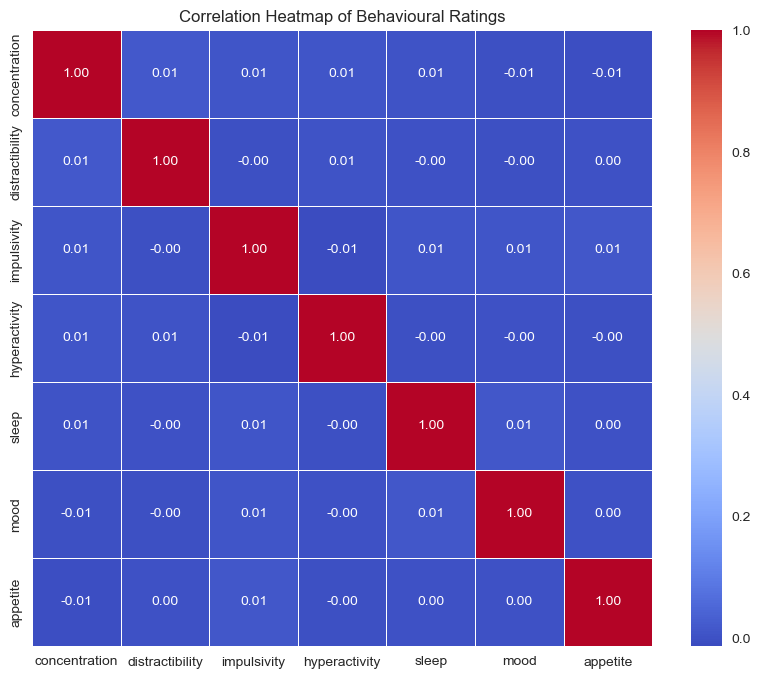

In [69]:
# Correlation heatmap between behaviour fields
plt.figure(figsize=(10, 8))
behaviour_corr = df[behavioural_cols].corr()
sns.heatmap(behaviour_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Behavioural Ratings')
plt.show()

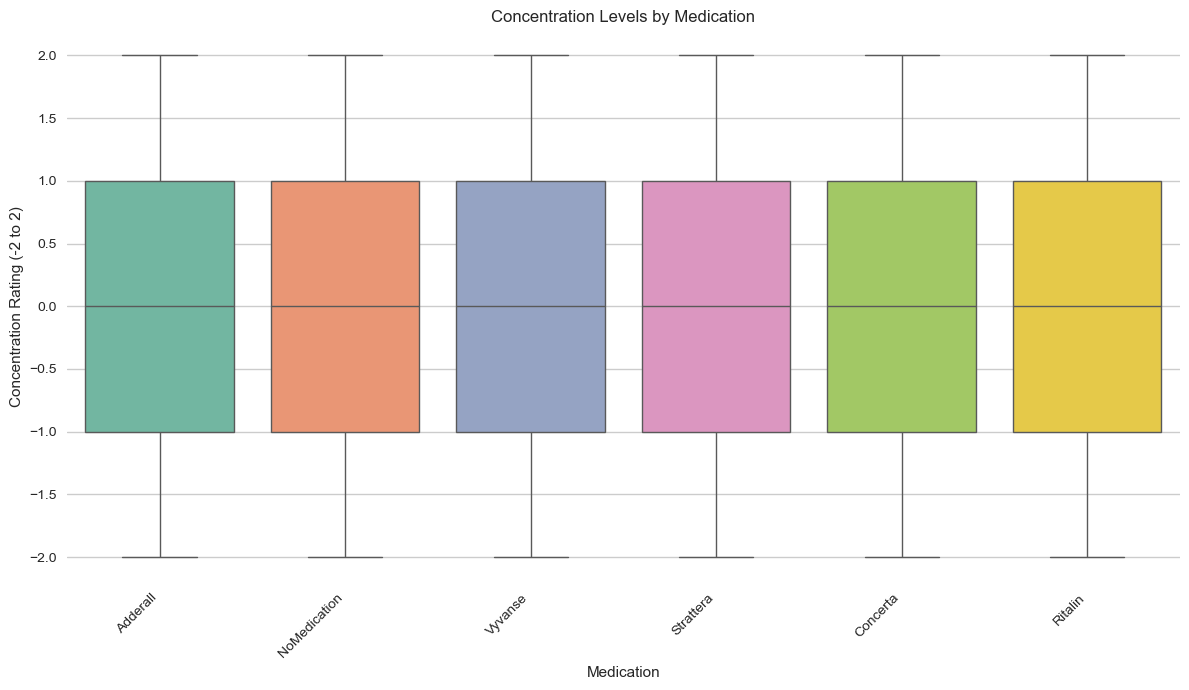

In [70]:
# Boxplot: concentration vs medication
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='medication', y='concentration', palette='Set2')
plt.title('Concentration Levels by Medication')
plt.xlabel('Medication')
plt.ylabel('Concentration Rating (-2 to 2)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

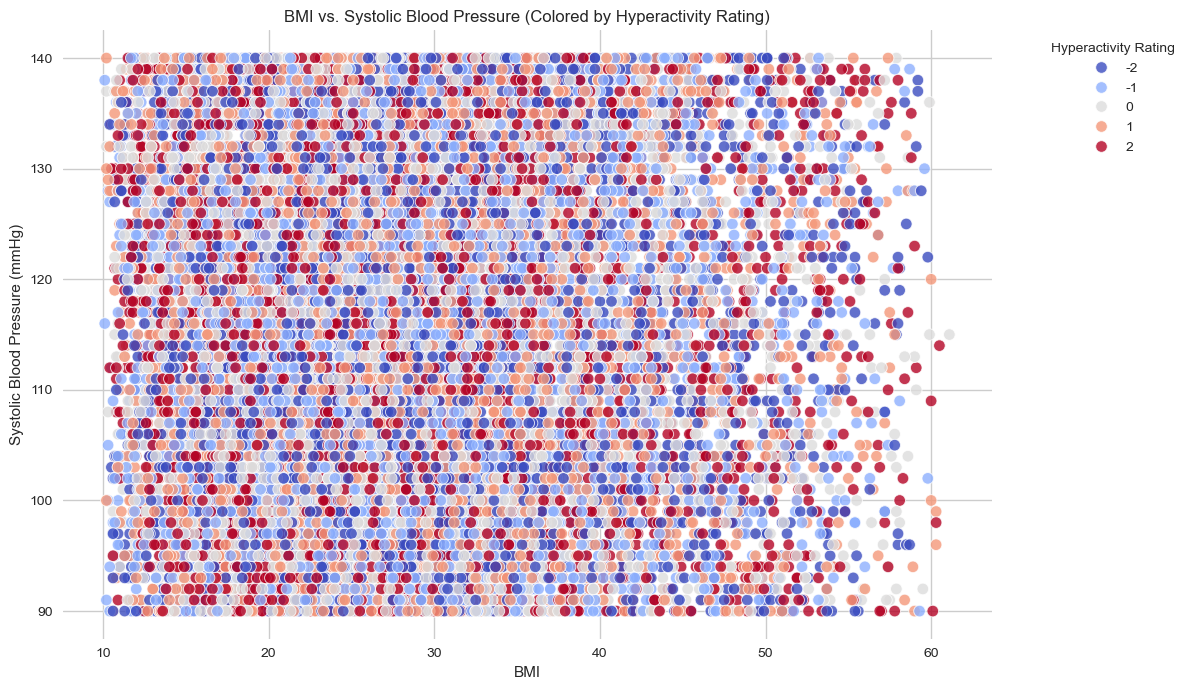

In [71]:
# Scatter plot: BMI vs systolic, coloured by hyperactivity
plt.figure(figsize=(12, 7))
scatter_plot = sns.scatterplot(data=df, x='bmi', y='systolic', hue='hyperactivity', palette='coolwarm', s=70, alpha=0.8)
plt.title('BMI vs. Systolic Blood Pressure (Colored by Hyperactivity Rating)')
plt.xlabel('BMI')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend(title='Hyperactivity Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4. Key Findings

In [ ]:
#save the processed data
df.to_csv('data/cleaned_patient_behavior_data.csv', index=False)